# Simulation of the "Punch" shot in carrom
**How should you hit a punch shot so that the coin goes as parallel to the wall as possible?**

Contact modelling is done using formulae given in  
*Popov, Valentin L., Markus Heß, and Emanuel Willert. Handbook of contact mechanics: exact solutions of axisymmetric contact problems. Springer Nature, 2019.*  
or on the *Contact Mechanics* wikipedia page (https://en.wikipedia.org/wiki/Contact_mechanics).

It is a simple N-body (3-body, really) code with a central force $F\propto(r_0-r)$. The Newton's differential equations are solved using scipy's `solve_ivp`

## Preamble

In [1]:
import numpy as np # For basic mathematical calculations
from scipy.integrate import solve_ivp # For solving differential equation of F = ma
from tqdm import tqdm # Gives a progress bar for loops
import os # for checking whether files exist

# For making pretty plots
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rc_params = {'axes.labelsize': 18,
             'axes.titlesize': 15,
             'font.size': 15,
             'lines.linewidth' : 2,
             'legend.fontsize': 12,
             'xtick.labelsize': 14,
             'ytick.labelsize': 14
            }
rcParams.update(rc_params)

rc('text.latex', preamble='\\usepackage{txfonts}')
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)

## Real world data
### Radii and masses of the coin (c) and striker (s)

In [2]:
Rc = 15.5 # mm
Rs = 20.5 # mm
Mc = 5.0 # g
Ms = 15.0 # g

### Coefficients of contact force
Materials assumed are
* Wood for wall and coin, $E = 10$ GPa, $\nu = 0.4$
* Polymer resin for striker, $E = 4.43$ GPa, $\nu = 0.4$

The effective force coefficients are calculated using the parallel cylinders' formulae given in https://en.wikipedia.org/wiki/Contact_mechanics

In [3]:
E_cs = 3.7e9 # Pa
E_cw = 6.0e9 # Pa
E_sw = 3.7e9 # Pa
L = 8.0 # mm, thickness of the coin

# precalculate quantities for optimization

F_coef_cs = np.pi / 4.0 * E_cs * L * 1e-6
Rcs = Rc + Rs
F_coef_cw = np.pi / 4.0 * E_cw * L * 1e-6
F_coef_sw = np.pi / 4.0 * E_sw * L * 1e-6

In [4]:
def Force_cs(r):
    # r is the separation between the two objects
    # return the magnitude of the force
    if Rc + Rs > r:
        return F_coef_cs * (Rcs - r)
    else:
        return 0.0

def Force_cw(r):
    # r is the separation between the two objects
    # return the magnitude of the force
    if Rc > r:
        return F_coef_cw * (Rc - r)
    else:
        return 0.0

def Force_sw(r):
    # r is the separation between the two objects
    # return the magnitude of the force
    if Rs > r:
        return F_coef_sw * (Rs - r)
    else:
        return 0.0

## Simulation of a punch shot
### Coordinate system
$\delta$ is the gap between the edge of the coin and the wall  
$\alpha$ denotes the angular location of the point on the coin towards which the striker is made to go  
$\beta$ denotes the acute angle made by the striker's velocity with the wall  
$\theta$ denotes the angle between the final velocity of the coin and the wall  
All 2D vector components $(x,y)$ are denoted by complex numbers $x + i y$  
<img src="carrom_punch_coordinates.png" alt="coordinate system" width="560"/>

### Problem statements
1. If one hits the coin with the striker at a point given by $\alpha$, with an angle of attack given by $\beta$, what is the angle $\theta$ that the coin makes with the wall after the collision has occured?
2. What are the optimum values of $\alpha$ and $\beta$ that result in the flattest possible trajectories (i.e., minimum $\theta$) for a given gap $\delta$?

### Collision modelling
There are three forces into the picture:
* The force between the coin and the striker, acting to push them apart if they are touching, zero otherwise
* The force between the coin and the wall at y=0, acting to push the coin towards positive y direction if touching, zero otherwise
* The force between the striker and the wall at y=0, acting to push the striker towards positive y direction if touching, zero otherwise

Their magnitudes are given by the `Force_\*(r)` functions coded above.

### Solving the equations of motion
Check out the documentation of `scipy`'s `solve_ivp` here https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html  
We need to define our state variable, `Y`, and a function `dYdt` that gives its time derivative. Here `Y` will contain the positions and velocities of the coin and the striker. Since `solve_ivp` requires `Y` to be a 1D array of numbers, I will denote all 2D vectors by complex numbers whose real part will denote the x-value and imaginary part will denote the y-value.

### Simplifying assumptions
* Board friction is ignored. Also, the friction always acts in the direction opposite to the velocity and doesn't affect its direction. The collision itself lasts for a short time, so this is a good approximation.
* Spin and contact friction during collision are ignored. This is probably a good approximation because I measure spins of order 10 rad/s and speeds of order 1 m/s. For a disk-like striker of radius 0.02 m, this means that the rotational kinetic energy is $\sim (R_s\omega/v)^2 \sim 4\%$, which is rather small.
* Perfectly elastic collisions are assumed. Inelasticity may not affect the final directions much, but then it just might. Future work...

Of course, if the predicted optimal angle turns out right despite these approximations, never mind.

In [5]:
def dYdt(t, Y):
    # t is time, not needed here but that's the solve_ivp syntax
    # Y contains the state variable, positions X and velocities V of coin c and striker s
    Xc, Vc, Xs, Vs = Y
    # find the separation
    r_cs = np.abs(Xs-Xc)
    # calculate force magnitudes
    F_cs = Force_cs(r_cs)
    F_cw = Force_cw(Xc.imag) # wall at y=0
    F_sw = Force_sw(Xs.imag) # wall at y=0
    
    # find time derivatives, xdot = v, vdot = a = F/m
    dXcdt = Vc
    dVcdt = (F_cs * (Xc - Xs) / r_cs + 1j * F_cw) * 1000.0 / Mc
    dXsdt = Vs
    dVsdt = (F_cs * (Xs - Xc) / r_cs + 1j * F_cs) * 1000.0 / Ms
    return [dXcdt, dVcdt, dXsdt, dVsdt]

In [6]:
def calculate_theta(Y0, t_max, t_more = 0.0):
    # Y0 are the initial positions and velocities of coin and striker
    # t_max is the maximum amount of time for which the simulation will be run
    # t_more is used to rerun the simulation from t_more to t_max + t_more
    
    # obtain the numerical solution to the equations of motion
    sol = solve_ivp(dYdt, [0 + t_more, t_max + t_more], Y0, method = 'DOP853', rtol = 1e-6)
    # theta is the angle the coin's velocity vector makes with the wall, apart from rad to deg conversion
    theta = 180.0 - np.angle(sol.y[1][-1]) * 180.0 / np.pi
    if theta < 180.0: # this means the coin is moving away from the wall
        return theta
    else: # sometimes, for large deltas, the coin might be moving downwards for a short amount of time, so simulate some more
        Y0 = [y[-1] for y in sol.y] # redefine final state as the new initial state
        return calculate_theta(Y0, t_max, t_more = t_max)

## Generating initial conditions

In [7]:
def generate_Y0(delta, alpha, beta = None, V = 1000.0, idelta = 1.2 * Rs):
    # refer to the coordinate system shown above for alpha, beta, delta
    # V is the speed in mm/s
    # (idelta - Rs) is the initial separation between the coin and the striker's edges
    
    if beta is None: beta = alpha # this means a head-on collision
    alpha *= np.pi / 180.0 # conversion to radians
    beta *= np.pi / 180.0
    
    # some vector and complex algebra here
    Xc = 1j * (delta + Rc)
    Vc = 0.0 + 1j * 0.0
    Xs = Xc + Rc * np.exp(1j * alpha) + idelta * np.exp(1j * beta)
    Vs = -V * np.exp(1j * beta)

    if np.abs(Xs - Xc) > 1 + (Rc + Rs):
        return [Xc, Vc, Xs, Vs]
    else: # if you end up having the coin and striker intersecting each other, recalculate with a higher initial separation
        return generate_Y0(delta, alpha * 180 / np.pi, beta = beta * 180 / np.pi, V = V, idelta = idelta + 0.1 * Rs)

## Testing the simulation for a particular case

theta from sol = 51.1 degrees
theta from function = 51.1 degrees


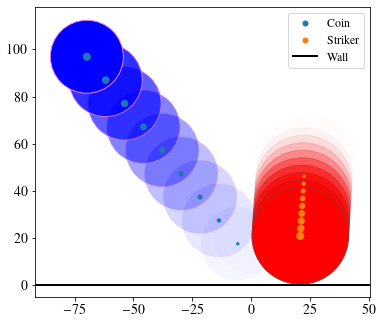

In [8]:
V = 100.0
t_max = 100.0 / V # rough estimate of t_max
Y0 = generate_Y0(5.0, 5.0, beta=75.0, V=V) # generate initial conditions

# t_eval = np.linspace(0.0,t_max / 5.0,10) # duration of the collision (for these input parameters)
t_eval = np.linspace(0.0,t_max,10) # change from 10 to get more or fewer snapshots

sol = solve_ivp(dYdt, [t_eval.min(),t_eval.max()], Y0, t_eval=t_eval, method = 'DOP853', rtol = 1e-6) # solve EOM
theta = 180.0 - np.angle(sol.y[1][-1]) * 180.0 / np.pi # calculate theta
print('theta from sol = %.1f degrees' % theta)
print('theta from function = %.1f degrees' % calculate_theta(Y0, t_max)) # same thing, but using the function defined above

# plot the trajectories
fig,ax = plt.subplots(figsize=(6,6))
for i in range(len(sol.t)):
    ax.add_patch(plt.Circle((sol.y[0][i].real, sol.y[0][i].imag), Rc, ec = 'violet', fc='blue', alpha=((i+1.0)/len(sol.t))**2.0))
    ax.add_patch(plt.Circle((sol.y[2][i].real, sol.y[2][i].imag), Rs, ec = 'brown', fc='red', alpha=((i+1.0)/len(sol.t))**2.0))
plt.scatter(sol.y[0].real, sol.y[0].imag, marker='.', s=200*sol.t/sol.t.max(), label = 'Coin')
plt.scatter(sol.y[2].real, sol.y[2].imag, marker='.', s=200*sol.t/sol.t.max(), label = 'Striker')
ax.set_aspect('equal')
plt.axhline(y=0, color='k', linestyle='-', label='Wall')
plt.legend()
plt.show()

Neat!  
You can try changing the parameters and see what happens. If you find that the two printed $\theta$'s are different, it probably means that your simulation stopped before the coin could bounce off the wall. Try running for longer `t_max`

If you want to look at what happens during to the collision, try to bracket that timeslot in `t_eval`

## Finding the optimum angle of attack for head-on collision
A head-on collision means $\alpha=\beta$. This is where the striker's center moves directly towards the coin's center. The variable is where the point of impact occurs on the edge of the coin, parameterized by $\alpha$.

We are trying to find the best way to hit the punch shot, i.e. to hit it so that the coin goes as close to parallel as possible to the wall. To find it, we are going to sweep the parameter space of $\alpha,\ \delta,\ V$ to find the combinations that result in the smallest possible values of $\theta$.

It's quite slow. A single calculation takes 0.02 seconds on average. I am sure a C++ implementation will be at least an order of magnitude faster. But for now, here we go...

In [9]:
rerun = False
outfile = './punch_headon_alpha90_delta100_V2.npz'

if rerun or not os.path.exists(outfile):
    alphas = np.linspace(1e-2, 90.0, 90)
    deltas = np.logspace(-2, 1, 100)
    Vs = np.array([100.0, 300.0, 900.0])
    thetas = np.empty((alphas.shape[0], deltas.shape[0], Vs.shape[0]))
    for i, alpha in tqdm(enumerate(alphas)):
        for j, delta in enumerate(deltas):
            for k, V in enumerate(Vs):
                Y0 = generate_Y0(delta, alpha, V=V)
                if Y0[2].imag < Rs:
                    thetas[i,j,k] = np.nan
                else:
                    thetas[i,j,k] = calculate_theta(Y0, t_max = 100.0 / V)
    np.savez(outfile, alphas = alphas, deltas = deltas, Vs = Vs, thetas = thetas)
else:
    data = np.load(outfile)
    alphas = data['alphas']
    deltas = data['deltas']
    Vs = data['Vs']
    thetas = data['thetas']

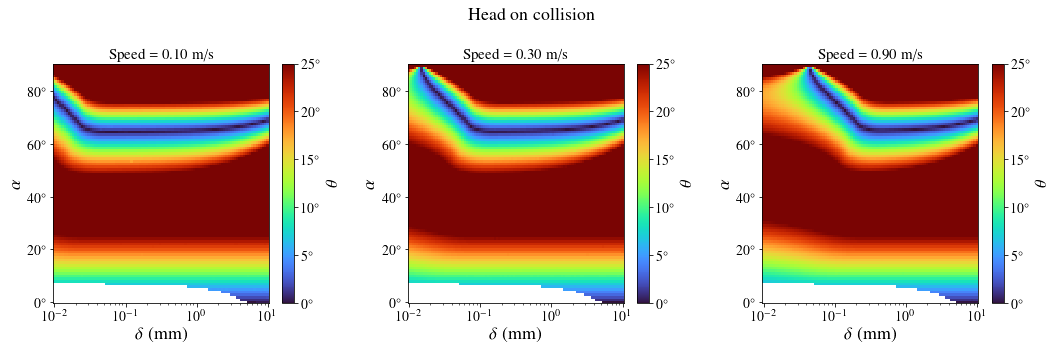

In [10]:
plt.figure(figsize=(5 * Vs.shape[0], 5))
for i in range(Vs.shape[0]):
    plt.subplot(101 + i + 10 * Vs.shape[0])
    plt.pcolor(deltas, alphas, thetas[:,:,i], cmap='turbo')
    plt.xscale('log')
    cbar = plt.colorbar()
    plt.clim([0,25])
    cbar.set_label(r'$\theta$')
    plt.xlabel(r'$\delta$ (mm)')
    plt.ylabel(r'$\alpha$')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
    cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
    plt.title('Speed = %.2f m/s' % (Vs[i] / 1000.0))

plt.suptitle('Head on collision')
plt.tight_layout()
plt.show()

### Performing a real experiment
Here are three screenshots from a slow-mo at 60 fps. The black marks on the coin denote $\alpha=\beta=65^\circ$. Striker speed was measured to be $\approx 1.2$ m/s, and it spun by $\approx 9.5$ rad/s after collision.

<img src="Before.jpg" alt="before impact" width="280"/> <img src="JustBefore.jpg" alt="just before impact" width="280"/> <img src="After.jpg" alt="after impact" width="280"/>

### Inferences
describe

optimum angle

behaviour vs speed, delta and etc

## Oblique collision
An oblique collision means that $\alpha \neq \beta$. The center of the striker is no longer directly moving towards the center of the coin. The point of impact may not correspond to the point on the edge of the coin which makes an angle $\alpha$ with the wall.

The procedure for finding the minimum of $\theta$ is same as before, only this time, we also have $\beta$ in the set of parameters to be swept.

### $\alpha$ vs $\delta$ for a few $\beta$'s and $V$'s

In [11]:
rerun = False
outfile = './punch_oblique_alpha45_beta3_delta50_V2.npz'

if rerun or not os.path.exists(outfile):
    alphas = np.linspace(1e-2, 90.0, 45)
    betas = np.array([30.0, 45.0, 60.0])
    deltas = np.logspace(-2, 1, 50)
    Vs = np.array([100.0, 900.0])
    thetas = np.empty((alphas.shape[0], betas.shape[0], deltas.shape[0], Vs.shape[0]))
    for i, alpha in tqdm(enumerate(alphas)):
        for j, beta in enumerate(betas):
            for k, delta in enumerate(deltas):
                for l, V in enumerate(Vs):
                    Y0 = generate_Y0(delta, alpha, beta=beta, V=V)
                    if Y0[2].imag < Rs:
                        thetas[i,j,k,l] = np.nan
                    else:
                        thetas[i,j,k,l] = calculate_theta(Y0, t_max = 100.0 / V)
    np.savez(outfile, alphas = alphas, betas = betas, deltas = deltas, Vs = Vs, thetas = thetas)
else:
    data = np.load(outfile)
    alphas = data['alphas']
    betas = data['betas']
    deltas = data['deltas']
    Vs = data['Vs']
    thetas = data['thetas']

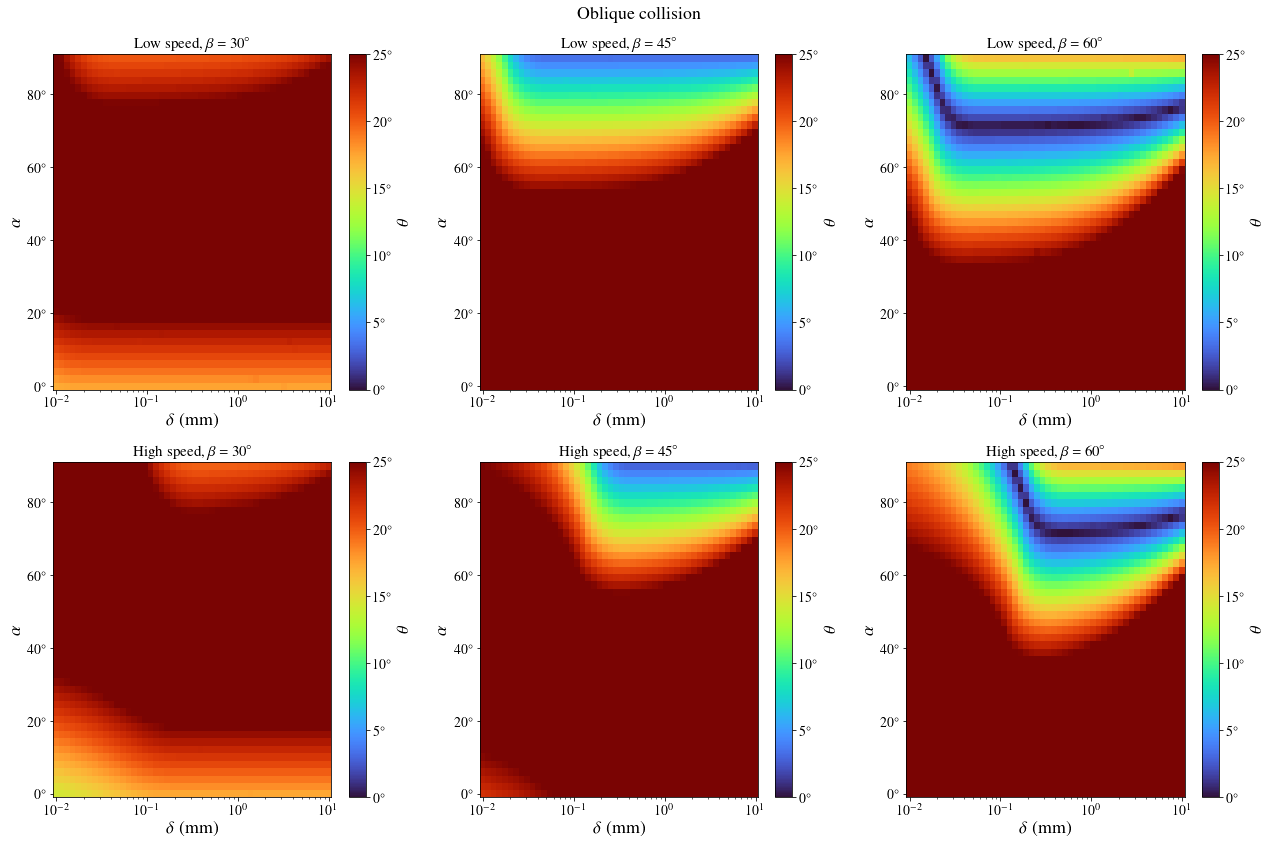

In [12]:
plt.figure(figsize=(18,12))

plt.subplot(231)
plt.pcolor(deltas, alphas, thetas[:,0,:,0], cmap='turbo')
plt.xscale('log')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\delta$ (mm)')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'Low speed, $\beta=30^\circ$')

plt.subplot(232)
plt.pcolor(deltas, alphas, thetas[:,1,:,0], cmap='turbo')
plt.xscale('log')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\delta$ (mm)')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'Low speed, $\beta=45^\circ$')

plt.subplot(233)
plt.pcolor(deltas, alphas, thetas[:,2,:,0], cmap='turbo')
plt.xscale('log')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\delta$ (mm)')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'Low speed, $\beta=60^\circ$')

plt.subplot(234)
plt.pcolor(deltas, alphas, thetas[:,0,:,1], cmap='turbo')
plt.xscale('log')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\delta$ (mm)')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'High speed, $\beta=30^\circ$')

plt.subplot(235)
plt.pcolor(deltas, alphas, thetas[:,1,:,1], cmap='turbo')
plt.xscale('log')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\delta$ (mm)')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'High speed, $\beta=45^\circ$')

plt.subplot(236)
plt.pcolor(deltas, alphas, thetas[:,2,:,1], cmap='turbo')
plt.xscale('log')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\delta$ (mm)')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'High speed, $\beta=60^\circ$')

plt.suptitle('Oblique collision')
plt.tight_layout()
plt.show()

### $\alpha$ vs $\beta$ for a few $\delta$'s and $V$'s

In [13]:
rerun = False
outfile = './punch_oblique_alpha45_beta45_delta3_V2.npz'

if rerun or not os.path.exists(outfile):
    alphas = np.linspace(1e-2, 90.0, 45)
    betas = np.linspace(1e-2, 90.0, 45)
    deltas = np.array([5.0e-2, 5.0e-1, 5.0e-0])
    Vs = np.array([100.0, 900.0])
    thetas = np.empty((alphas.shape[0], betas.shape[0], deltas.shape[0], Vs.shape[0]))
    for i, alpha in tqdm(enumerate(alphas)):
        for j, beta in enumerate(betas):
            for k, delta in enumerate(deltas):
                for l, V in enumerate(Vs):
                    Y0 = generate_Y0(delta, alpha, beta=beta, V=V)
                    if Y0[2].imag < Rs:
                        thetas[i,j,k,l] = np.nan
                    else:
                        thetas[i,j,k,l] = calculate_theta(Y0, t_max = 100.0 / V)
    np.savez(outfile, alphas = alphas, betas = betas, deltas = deltas, Vs = Vs, thetas = thetas)
else:
    data = np.load(outfile)
    alphas = data['alphas']
    betas = data['betas']
    deltas = data['deltas']
    Vs = data['Vs']
    thetas = data['thetas']

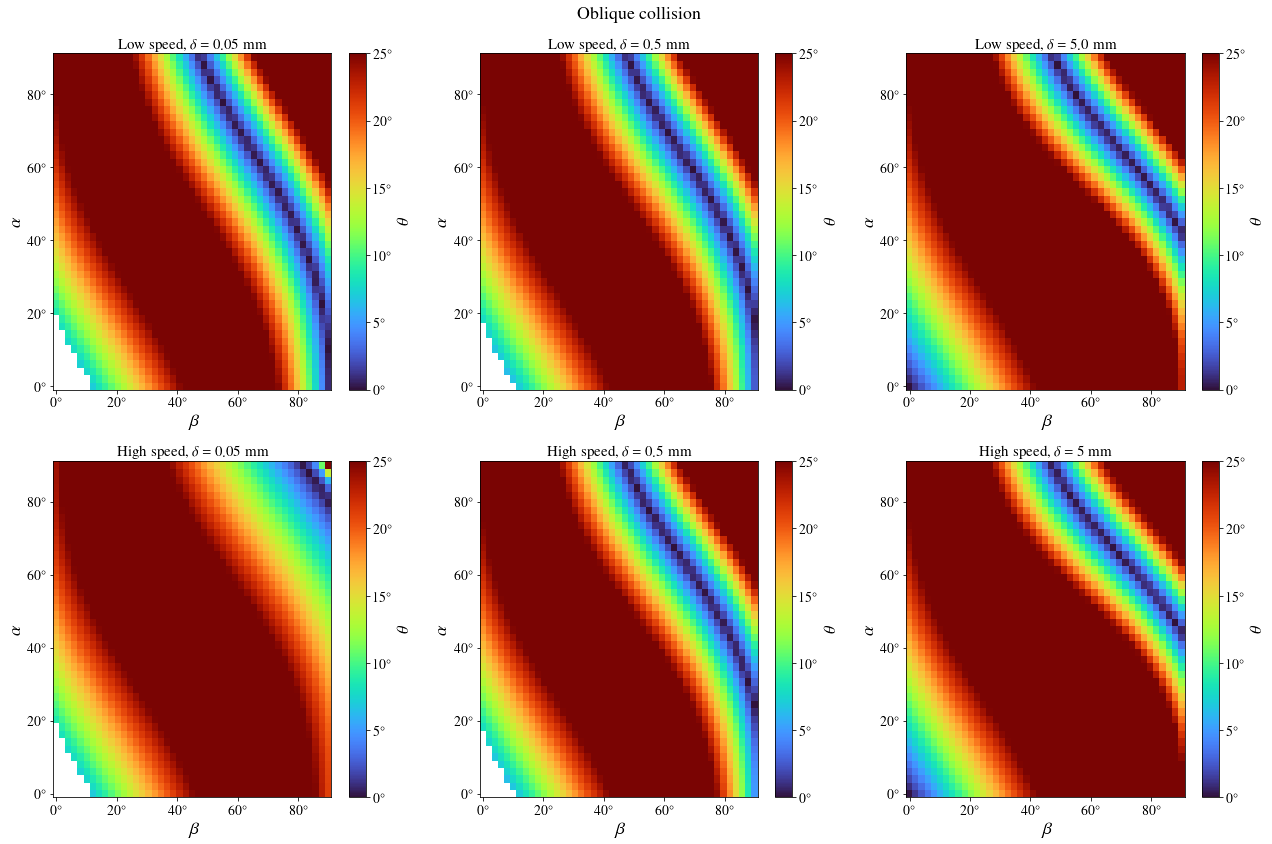

In [14]:
plt.figure(figsize=(18,12))

plt.subplot(231)
plt.pcolor(betas, alphas, thetas[:,:,0,0], cmap='turbo')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'Low speed, $\delta=0.05$ mm')

plt.subplot(232)
plt.pcolor(betas, alphas, thetas[:,:,1,0], cmap='turbo')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'Low speed, $\delta=0.5$ mm')

plt.subplot(233)
plt.pcolor(betas, alphas, thetas[:,:,2,0], cmap='turbo')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'Low speed, $\delta=5.0$ mm')

plt.subplot(234)
plt.pcolor(betas, alphas, thetas[:,:,0,1], cmap='turbo')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'High speed, $\delta=0.05$ mm')

plt.subplot(235)
plt.pcolor(betas, alphas, thetas[:,:,1,1], cmap='turbo')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'High speed, $\delta=0.5$ mm')

plt.subplot(236)
plt.pcolor(betas, alphas, thetas[:,:,2,1], cmap='turbo')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'High speed, $\delta=5$ mm')

plt.suptitle('Oblique collision')
plt.tight_layout()
plt.show()

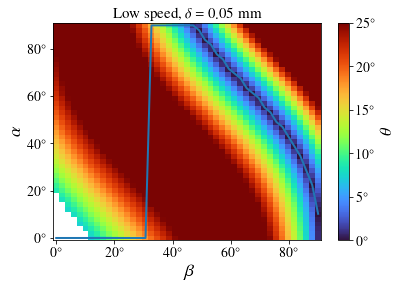

In [15]:
betas_min = betas.copy()
alphas_min = alphas[np.argmin(thetas[:,:,0,0], axis=0)]

plt.pcolor(betas, alphas, thetas[:,:,0,0], cmap='turbo')
cbar = plt.colorbar()
plt.clim([0,25])
cbar.set_label(r'$\theta$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
ax = plt.gca()
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
cbar.ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.title(r'Low speed, $\delta=0.05$ mm')

plt.plot(betas_min, alphas_min)
plt.show()

In [16]:
def point_of_impact(Y0):
    Xc, _, Xs, Vs = Y0
    idelta_vec = Xc - Xs
    idelta = np.abs(idelta_vec)
    cosa = np.real(idelta_vec * np.conj(Vs)) / idelta / np.abs(Vs)
    if cosa > 1: cosa = 1
    sina = np.sqrt(1 - cosa ** 2.0)
    b = np.arcsin(sina * idelta / (Rc + Rs))
    return 180.0 / np.pi * (np.angle(-idelta_vec) + np.arcsin(sina) - b)

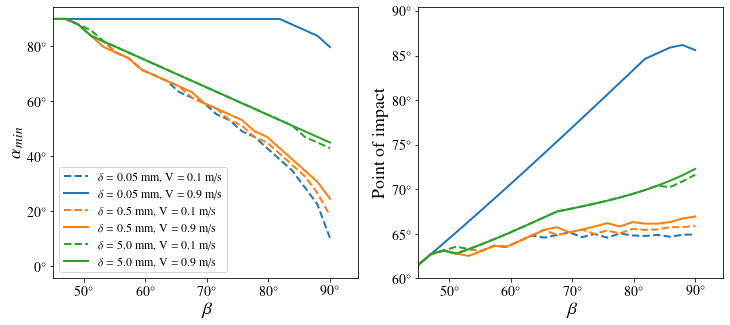

In [36]:
lss = ['--', '-']
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize = (12,5))

plt.subplot(121)
for i in range(3):
    for j in range(2):
        betas_min = betas.copy()
        alphas_min = alphas[np.argmin(thetas[:,:,i,j], axis=0)]
        plt.plot(betas, alphas_min, color = colors[i], ls=lss[j], label=r'$\delta=$ ' + str(deltas[i]) + ' mm, V = ' + str(Vs[j]/1000.0) + ' m/s')
        plt.xlim(left=45)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha_{min}$')
ax = plt.gca()
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.legend()

plt.subplot(122)
for i in range(3):
    for j in range(2):
        betas_min = betas.copy()
        alphas_min = alphas[np.argmin(thetas[:,:,i,j], axis=0)]
        poi = []
        for alpha, beta in zip(alphas_min, betas_min):
            Y0 = generate_Y0(deltas[i], alpha, beta=beta, V = Vs[j])
            poi.append(point_of_impact(Y0))
        plt.plot(betas, poi, color = colors[i], ls=lss[j], label=r'$\delta=$ ' + str(deltas[i]) + ' mm, V = ' + str(Vs[j]/1000.0) + ' m/s')

plt.xlim(left=45)
plt.ylim(bottom=60)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Point of impact')
ax = plt.gca()
ax.xaxis.set_major_formatter(r'{x:.0f}$^\circ$')
ax.yaxis.set_major_formatter(r'{x:.0f}$^\circ$')
plt.show()

### Inferences

optimum angle

behaviour vs speed, delta and etc

## Conclusions
**For typical gaps and speeds, aim for an impact at $65^\circ$ on the coin**

<img src="optimum_poi.png" alt="Optimum point of impact" width="250"/>

I had earlier used the sphere-sphere contact potential formulae, where the force goes as $(r_0-r)^{3/2}$ instead of $(r_0-r)$. That was one mistake. On top of it, I had forgotten to convert from mm to m while calculating the force, resulting in a million times higher forces. Strangely, the final results at *low speeds* were very similar to what they are now. I suppose it means that the detailed microphysics of collision doesn't matter much when it comes to the punch shot's macrophysics, at low impact speeds.

future work